In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ecdc_data = pd.read_csv("./ECDC_surveillance_data_Rubella.csv")
ecdc_data

,HealthTopic,Population,Distribution,Unit,Time,RegionCode,RegionName,CategoryIndex,Category,Value
0,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,1,<1,0.000000000
1,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,2,1-4,0.000000000
2,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,3,5-9,0.000000000
3,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,4,10-14,0.000000000
4,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,5,15-19,0.000000000
...,...,...,...,...,...,...,...,...,...,...
4237,Rubella,All cases - Most recent 12 months only,Distribution by complications,%,2019-12,UK,United Kingdom,4,Neurological complications,-
4238,Rubella,All cases - Most recent 12 months only,Distribution by gender,%,2019-12,UK,United Kingdom,1,Male,33.333333330
4239,Rubella,All cases - Most recent 12 months only,Distribution by gender,%,2019-12,UK,United Kingdom,2,Female,66.666666660
4240,Rubella,All cases - Most recent 12 months only,Gender-specific rate,N/1000000,2019-12,UK,United Kingdom,1,Male,0.030571730


In [3]:
ecdc_data = ecdc_data.loc[lambda s: s['HealthTopic'] == 'Rubella']
ecdc_data = ecdc_data.loc[lambda s: s['Population'] == 'All cases']
ecdc_data

,HealthTopic,Population,Distribution,Unit,Time,RegionCode,RegionName,CategoryIndex,Category,Value
0,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,1,<1,0.000000000
1,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,2,1-4,0.000000000
2,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,3,5-9,0.000000000
3,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,4,10-14,0.000000000
4,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,5,15-19,0.000000000
...,...,...,...,...,...,...,...,...,...,...
2967,Rubella,All cases,Gender-specific rate,N/1000000,2019-10,UK,United Kingdom,2,Female,0.000000000
2968,Rubella,All cases,Gender-specific rate,N/1000000,2019-11,UK,United Kingdom,1,Male,0.000000000
2969,Rubella,All cases,Gender-specific rate,N/1000000,2019-11,UK,United Kingdom,2,Female,0.000000000
2970,Rubella,All cases,Gender-specific rate,N/1000000,2019-12,UK,United Kingdom,1,Male,0.000000000


In [4]:
ecdc_data = ecdc_data[['Distribution', 'Time','Category', 'Value']]

In [5]:
ecdc_age = ecdc_data.loc[lambda s: s['Distribution'] == "Age-specific rate"][['Time', 'Category', 'Value']]
ecdc_age

,Time,Category,Value
0,2007-01,<1,0.000000000
1,2007-01,1-4,0.000000000
2,2007-01,5-9,0.000000000
3,2007-01,10-14,0.000000000
4,2007-01,15-19,0.000000000
...,...,...,...
1087,2019-12,5-9,0.000000000
1088,2019-12,10-14,0.000000000
1089,2019-12,15-19,0.000000000
1090,2019-12,20-29,0.000000000


In [6]:
ecdc_age = ecdc_age.pivot(index='Time', columns='Category', values='Value')

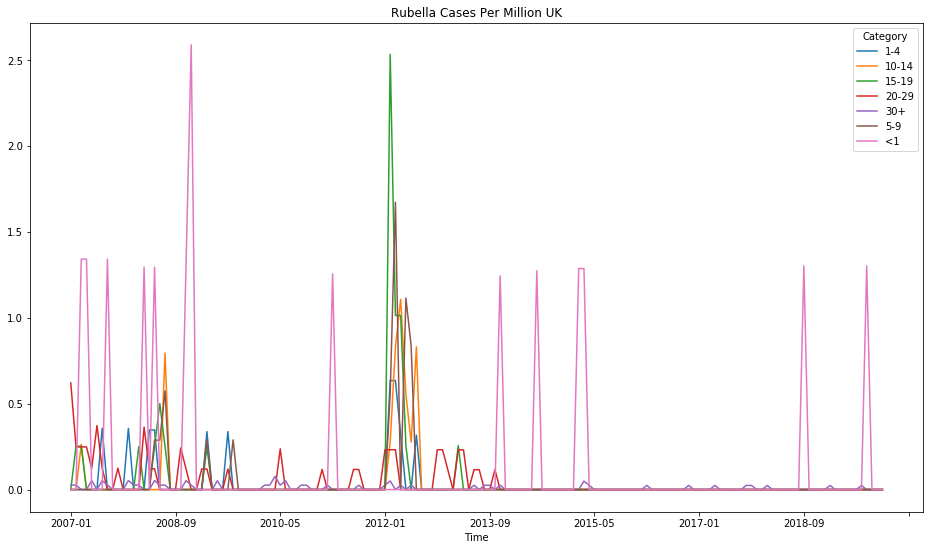

In [7]:
ecdc_age = ecdc_age.apply(pd.to_numeric) 
plot = ecdc_age.plot(figsize=(16,9),title="Rubella Cases Per Million UK")
plt.savefig("Rubella20072018")